In [1]:
import sys
sys.path.append('tm_navigator')

In [2]:
import re
from collections import Counter
import numpy as np
import scipy.sparse as sp
from scipy.spatial.distance import pdist, squareform
import codecs
import h5py
import itertools as it

import sqlalchemy as sa
import sqlalchemy.ext.hybrid
import sqlalchemy.ext.declarative as sa_dec
import sqlalchemy_searchable as searchable

from tm_navigator import models as m
from tm_navigator.models import *
import tm_navigator.assessment_models as am
from tm_navigator.assessment_models import *

In [3]:
engine = sa.create_engine('postgresql+psycopg2://@localhost/tm_navigator', echo=0)
sa.orm.configure_mappers()

In [4]:
Session = sa.orm.sessionmaker(bind=engine)

from contextlib import contextmanager

@contextmanager
def session_scope():
    """Provide a transactional scope around a series of operations."""
    session = Session()
    try:
        yield session
        session.commit()
    except:
        session.rollback()
        raise
    finally:
        session.close()

In [6]:
Base.metadata.create_all(engine)

In [5]:
Base.metadata.drop_all(engine)

In [ ]:
conn = engine.raw_connection()
with conn.cursor() as cursor:
    cursor.execute('''
    select tablename
    from pg_tables
    where schemaname = 'public';
    ''')
    tables = [r[0] for r in cursor.fetchall()]
    print('\n'.join(tables))
    if input() == 'y':
        for t in tables:
            print('drop table "%s" cascade;' % t)
            cursor.execute('drop table "%s" cascade' % t)
    cursor.execute('commit')

In [8]:
%%file schemadisplay.py
import sqlalchemy as sa
from sqlalchemy_schemadisplay import create_schema_graph

# create the pydot graph object by autoloading all tables via a bound metadata object
graph = create_schema_graph(metadata=sa.MetaData('postgresql+psycopg2://@localhost/tm_navigator'))
graph.write_png('dbschema.png') # write out the file

Overwriting schemadisplay.py


In [8]:
!python2 schemadisplay.py

Couldn't import dot_parser, loading of dot files will not be possible.


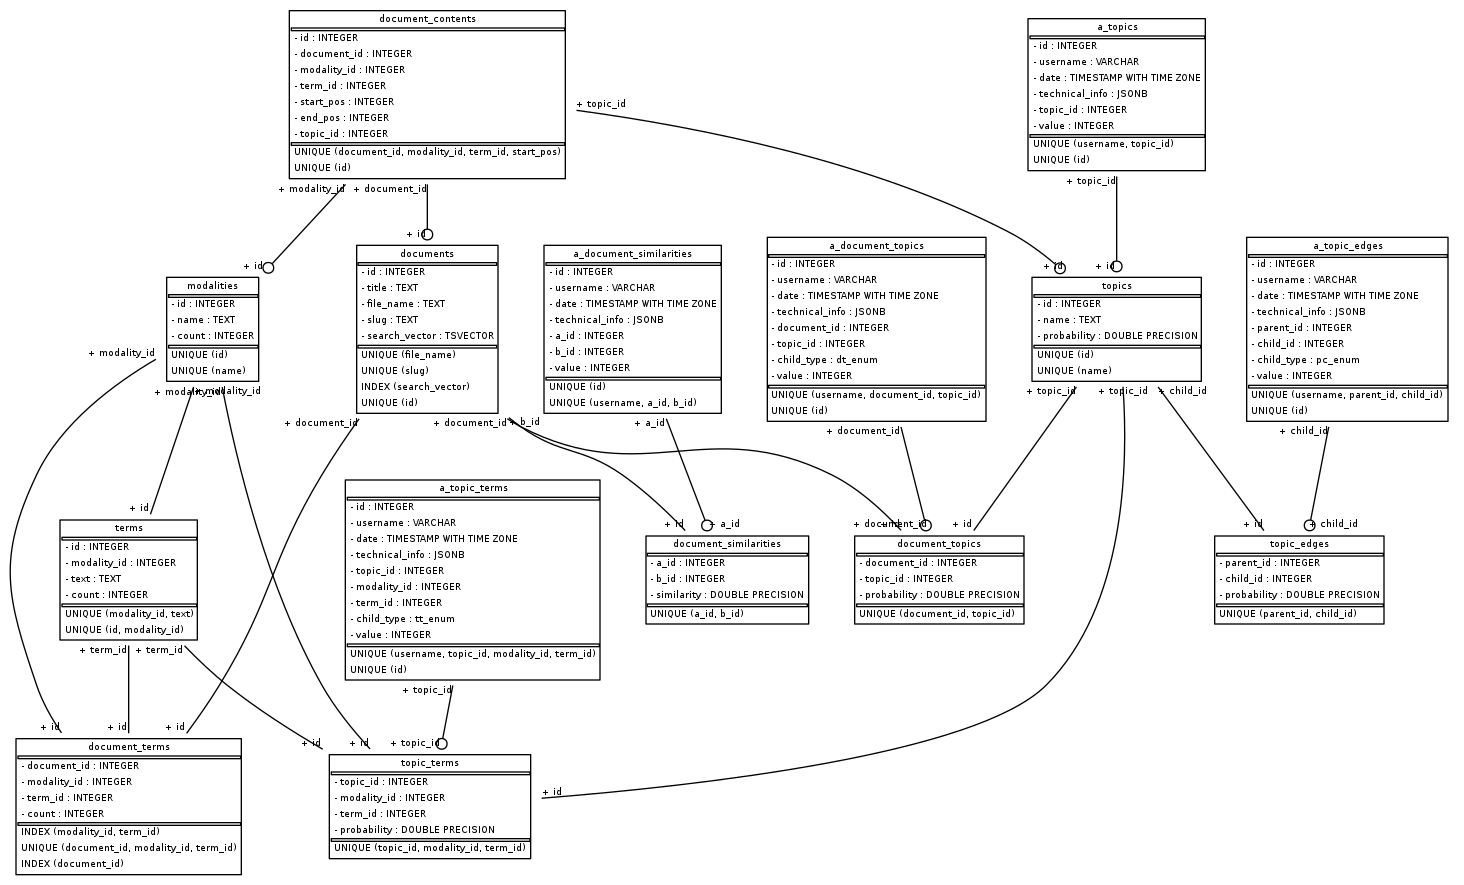

In [9]:
from IPython.display import display, Image

display(Image(filename='dbschema.png'))

In [30]:
import sadisplay
from IPython.display import display, Image

classes = [c
           for c in Base._decl_class_registry.values()
           if 'Dummy' not in getattr(c, '__name__', 'Dummy')]
desc = sadisplay.describe(classes)
open('dbschema.dot', 'w').write(sadisplay.dot(desc))
!dot -Tpng dbschema.dot > dbschema.png

display(Image(filename='dbschema.png'))

ImportError: No module named 'sadisplay'

In [7]:
from sqlalchemy_utils import aggregates

aggregates.local_condition = lambda prop, objects: sa.literal(True)

class ListSession(list):
    def execute(self, query):
        print(query)
        return session.execute(query)

def update_aggregates(*classes_modified):
    aggregates.manager.construct_aggregate_queries(
        ListSession([c() for c in classes_modified]),
        None)

In [8]:
import csv
from io import StringIO
from contextlib import closing

def copy_to_table(session, model, rows):
    firstrow = next(rows)
    fieldnames = firstrow.keys()

    with closing(StringIO()) as csv_f:
        writer = csv.DictWriter(csv_f, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerow(firstrow)
        writer.writerows(rows)
        csv_f.seek(0)

        with session.connection().connection.cursor() as cursor:
            cursor.copy_expert('copy %s (%s) from stdin with csv header' % (model.__tablename__, ', '.join(fieldnames)), csv_f)
            
    
    update_aggregates(model)

In [9]:
with session_scope() as session:
    session.add(Modality(name='words'))

In [10]:
with open('data/dictionary.mmro.txt') as f, session_scope() as session:
    modality = session.query(Modality).filter(Modality.name == 'words').one()
    rows = (dict(id=i, modality_id=modality.id, text=line.strip())
            for i, line in enumerate(f))
    copy_to_table(session, Term, rows)
    
    print(session.query(Term).count())

UPDATE modalities SET count=(SELECT count(*) AS count_1 
FROM terms 
WHERE modalities.id = terms.modality_id) WHERE :param_1
7805


In [11]:
with h5py.File('data/data.hdf') as h5f:
    metadata = h5f['metadata'][...]

In [12]:
%%time
with session_scope() as session:
    rows = (
        dict(id=i, title=t['title'], file_name=t['filename'], slug=t['slug'],
             source=re.sub(r'^\d{4}-([A-Z]+)(\d+)/.+', r'\1-\2', t['filename']),
             html=open('data/html_sprites/%s.html' % t['filename']).read())
        for i, t in enumerate(metadata)
    )
    copy_to_table(session, Document, rows)
    
    print(session.query(Document).count())

1061
CPU times: user 1.56 s, sys: 208 ms, total: 1.76 s
Wall time: 9.17 s


In [13]:
with session_scope() as session:
    session.add(Modality(name='authors'))

In [14]:
%%time
with session_scope() as session:
    m = session.query(Modality).filter(Modality.name == 'authors').one()
    
    doc_authors = [(i, author.strip())
         for i, m in enumerate(metadata)
         for author in m['authors'].split(',')
    ]
    authors = {a for d, a in doc_authors}
    authors_terms = {a: Term(modality=m, text=a)
                     for a in authors}
    session.add_all(
        DocumentTerm(document_id=d, term=authors_terms[a], count=1)
        for d, a in doc_authors)

CPU times: user 1.54 s, sys: 88 ms, total: 1.63 s
Wall time: 2.77 s


In [15]:
%%time
with open('data/documents.mmro.txt') as f, session_scope() as session:
    m_id = session.query(Modality.id).filter(Modality.name == 'words').scalar()
    
    rows = (dict(document_id=d, modality_id=m_id, term_id=w, count=cnt)
             for d, line in enumerate(f)
             for w, cnt in Counter(int(dw.split()[0]) for dw in line.split(';')[:-1]).items())

    copy_to_table(session, DocumentTerm, rows)
    
    print(session.query(DocumentTerm.modality_id, sa.func.count()).group_by(DocumentTerm.modality_id).all())

UPDATE terms SET count=(SELECT coalesce(sum(document_terms.count), :param_1) AS coalesce_1 
FROM document_terms 
WHERE terms.modality_id = document_terms.modality_id AND terms.id = document_terms.term_id) WHERE :param_2
[(2, 2315), (1, 314081)]
CPU times: user 2.94 s, sys: 28 ms, total: 2.96 s
Wall time: 25.2 s


In [16]:
%%time
with open('data/documents.mmro.txt') as f, session_scope() as session:
    m_id = session.query(Modality.id).filter(Modality.name == 'words').scalar()

    id_cnt = it.count()
    rows = (dict(id=next(id_cnt), document_id=d, modality_id=m_id, term_id=w, start_pos=s, end_pos=e)
            for d, line in enumerate(f)
            for w, s, e in (map(int, dw.split()) for dw in line.split(';')[:-1]))

    copy_to_table(session, DocumentContent, rows)

CPU times: user 10.1 s, sys: 176 ms, total: 10.2 s
Wall time: 1min 1s


In [17]:
phi = sp.coo_matrix(np.load('data/phi.npy'))
theta = sp.coo_matrix(np.load('data/theta.npy'))

In [18]:
pwt = phi.A
ptd = theta.A

pd = 1.0 / theta.shape[1]
pt = (ptd * pd).sum(1)
pw = (pwt * pt).sum(1)
ptw = pwt * pt / pw[:, np.newaxis]
pdt = ptd * pd / pt[:, np.newaxis]

In [19]:
%%time
with session_scope() as session:
    m_id = session.query(Modality.id).filter(Modality.name == 'words').scalar()
    
    session.add(Topic(id=0, type='foreground'))

    t_to_id = lambda level, t: level * 1000 + t

    copy_to_table(session, Topic,
                  (dict(id=t_to_id(1, t), type='foreground' if t < 50 else 'background')
                   for t in range(phi.shape[1])
                  ))
    rows = (dict(topic_id=t_to_id(1, t), modality_id=m_id, term_id=w, prob_wt=val, prob_tw=ptw[w, t])
            for w, t, val in zip(phi.row, phi.col, phi.data))
    copy_to_table(session, TopicTerm, rows)

    rows = (dict(topic_id=t_to_id(1, t), document_id=d, prob_td=val, prob_dt = pdt[t, d])
            for t, d, val in zip(theta.row, theta.col, theta.data))
    copy_to_table(session, DocumentTopic, rows)
            
    
    print(session.query(Topic.level, sa.func.count()).group_by(Topic.level).all())
    print(session.query(Topic.level, sa.func.count()).join(DocumentTopic).group_by(Topic.level).all())
    print(session.query(Topic.level, sa.func.count()).join(TopicTerm).group_by(Topic.level).all())

UPDATE topics SET probability=(SELECT coalesce(sum(document_topics.prob_td), :param_1) AS coalesce_1 
FROM document_topics 
WHERE topics.id = document_topics.topic_id) WHERE :param_2
[(0, 1), (1, 60)]
[(1, 14161)]
[(1, 120936)]
CPU times: user 5.08 s, sys: 12 ms, total: 5.1 s
Wall time: 12.9 s


In [20]:
with session_scope() as session:
    root = session.query(Topic).filter(Topic.level == 0).one()
    q = session.query(Topic).filter(Topic.level == 1)
    session.add_all(TopicEdge(parent=root, child=t, probability=t.probability) for t in q)

In [21]:
%%time
with open('data/ptdw.txt') as fp, session_scope() as session:
    id_cnt = it.count()
    rows = (dict(document_content_id=next(id_cnt), topic_id=1000 + int(t))
            for d, linep in enumerate(fp)
            for t in linep.split())

    copy_to_table(session, DocumentContentTopic, rows)

CPU times: user 5.4 s, sys: 36 ms, total: 5.44 s
Wall time: 39.5 s


In [22]:
%%time
with session_scope() as session:
    distances = squareform(pdist(theta.A.T, 'cosine'))

    rows = (dict(a_id=i, b_id=sim_i, similarity=1 - row[sim_i])
            for i, row in enumerate(distances)
            for sim_i in row.argsort()[:31]
            if sim_i != i)
    copy_to_table(session, DocumentSimilarity, rows)

CPU times: user 828 ms, sys: 8 ms, total: 836 ms
Wall time: 3.09 s


In [23]:
%%time
with session_scope() as session:
    distances = squareform(pdist(phi.A.T, 'cosine'))

    rows = (dict(a_id=t_to_id(1, i), b_id=t_to_id(1, sim_i), similarity=1 - row[sim_i])
            for i, row in enumerate(distances)
            for sim_i in row.argsort()[:]
            if sim_i != i)
    copy_to_table(session, TopicSimilarity, rows)

CPU times: user 96 ms, sys: 4 ms, total: 100 ms
Wall time: 313 ms


In [29]:
%%time
with session_scope() as session:
    m_id = session.query(Modality.id).filter(Modality.name == 'words').scalar()
#     distances = squareform(pdist(phi.A, 'cosine'))

    rows = (dict(a_modality_id=m_id, b_modality_id=m_id, a_id=i, b_id=sim_i, similarity=1 - row[sim_i])
            for i, row in enumerate(distances)
            for sim_i in row.argsort()[:20]
            if sim_i != i)
    copy_to_table(session, TermSimilarity, rows)

ERROR! Session/line number was not unique in database. History logging moved to new session 3710
CPU times: user 8.22 s, sys: 64 ms, total: 8.29 s
Wall time: 15.4 s


In [24]:
with session_scope() as session:
#     session.query(Term).\
#         update({Term.count:
#                 session.query(sa.sql.functions.coalesce(sa.func.sum(DocumentTerm.count), 0)).\
#                 filter_by(term_id=Term.id, modality_id=Term.modality_id).\
#                 subquery().as_scalar()},
#                synchronize_session=False)
    session.execute('''
    with counts as (
        select modality_id, term_id, sum(count)
        from document_terms
        group by modality_id, term_id
    )
    
    update terms
    set count = counts.sum
    from counts
    where counts.term_id = terms.id and counts.modality_id = terms.modality_id
    ''')
#     print session.query(Term.count == sa.func.sum(DocumentTerm.count)).join(DocumentTerm).group_by(Term).all()

In [26]:
with session_scope() as session:
    session.execute('''
    with probs as (
        select
            topic_id,
            sum(prob_td / (select count(*) from documents)) as probability
        from document_topics
        group by topic_id
    )
    
    update topics
    set probability = probs.probability
    from probs
    where topics.id = probs.topic_id
    ''')
    print(session.query(Topic.level, sa.func.sum(Topic.probability)).group_by(Topic.level).all())

[(1, 1.0000000060127), (0, 0.0)]


In [71]:
import sqlalchemy_utils

In [79]:
for k, v in sorted(sqlalchemy_utils.functions.non_indexed_foreign_keys(Base.metadata, engine).items()):
    print(k, ':', [fk.name for fk in v])

NameError: name 'sqlalchemy_utils' is not defined

In [ ]:
'-'*10000